In [1]:
import os

os.chdir('..')

In [9]:
import os
import itertools
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import laion_utils as laionu
from utils import utils
from core.retrieve_image import download_image
from core.queries import query_name_def, QueryType

# Settings

## Path

In [3]:
# LAION subset
laion_path = 'laion400m'
laion_until_part = 31
prefix = configs.NamingConfig.SUBSET_SM_PREFIX

# Labels (maps)
labels_path = os.path.join('laion400m', 'processed', 'ilsvrc_labels')
lemma_labels_filter = 'lemma2laionindices(substring_matched_part*).pkl'
wnid_labels_filter = 'wnid2laionindices(substring_matched_part*).pkl'

lemma2wnid_path = os.path.join('ilsvrc2012', 'processed', 'lemma2wnid(unique_in_ilsvrc_ignored_empty_wnids).pkl')

In [4]:
# q_type = QueryType.A_CLEAR_PHOTO_OF_NAME_DEF
q_type = QueryType.NAME_DEF
q_key = 'wnid'
text_encoder_ver = 'all-mpnet-base-v2'

q_col = q_type+ '_' + q_key
sim_col = f'text_to_{q_col}_similarity_{text_encoder_ver}'
    
print(sim_col)

text_to_name_def_wnid_similarity_all-mpnet-base-v2


# Init.

In [5]:
subset_file_name = prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)
subset_file_path = os.path.join(laion_path, subset_file_name)

# Load

## Load LAION subset

In [6]:
df = pd.read_parquet(subset_file_path)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,text_to_name_def_wnid_similarity_bert-base-uncased,text_to_name_def_wnid_similarity_all-mpnet-base-v2
60,2.105180e+12,https://rlv.zcache.com.au/archipelago144_i_mus...,"""Archipelago144 """"I Must Be A Mermaid"""" throw ...",324.0,324.0,?,UNLIKELY,0.331579,pillow which is a cushion to support the head ...,0.575911,0.716013,0.325995
69,1.127880e+12,http://images4-b.ravelrycache.com/uploads/Wool...,Oval_drum_small2,320.0,320.0,?,UNLIKELY,0.306868,drum which is a musical percussion instrument;...,0.853099,0.754025,0.430411
70,2.391401e+10,http://u.goal.com/175900/175958hp2.jpg,Senegal coach Joseph Koto to take revenge on C...,570.0,355.0,?,UNLIKELY,0.309802,passenger car which is a railcar where passeng...,0.557263,0.887987,-0.026932


### Drop NSFW

In [7]:
df.loc[df[configs.LAIONConfig.NSFW_COL] != configs.LAIONConfig.SAFE_TAG, sim_col] = np.nan

## Load maps

In [10]:
lemma_maps_paths = glob.glob(os.path.join(labels_path, lemma_labels_filter))

lemma_maps = []
for path in tqdm(lemma_maps_paths):
    with open(path, 'rb') as f:
        lemma2laionindices_i = pickle.load(f)
        lemma_maps.append(lemma2laionindices_i)
        
lemma2laionindices = utils.join_maps(lemma_maps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.16it/s]


In [11]:
wnid_maps_paths = glob.glob(os.path.join(labels_path, wnid_labels_filter))

wnid_maps = []
for path in tqdm(wnid_maps_paths):
    with open(path, 'rb') as f:
        wnid2laionindices_i = pickle.load(f)
        wnid_maps.append(wnid2laionindices_i)
        
wnid2laionindices = utils.join_maps(wnid_maps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.49it/s]


In [12]:
with open(lemma2wnid_path, 'rb') as f:
    lemma2wnid = pickle.load(f)

### Find the inverse map

In [13]:
wnid2lemmas = utils.find_inverse_map(lemma2wnid)

# Plot distributions

In [14]:
wnid = 'n02125311'

print(query_name_def(wnid))

cougar which is large American feline resembling a lion


found 3910 cougar
found 11437 puma
found 0 mountain lion
found 18356 painter
found 310 Felis concolor


Text(0, 0.5, 'pdf')

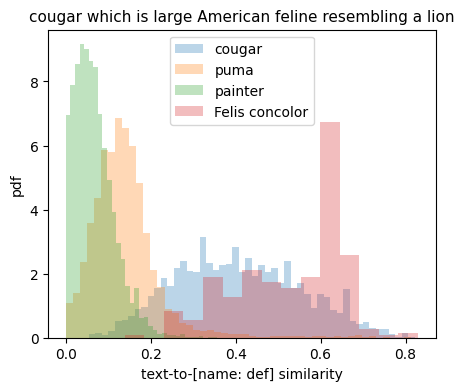

In [16]:
plt.figure(figsize=(5, 4))

lgnds = []
for lemma in wnid2lemmas[wnid]:
    if lemma not in lemma2laionindices:
        print(f'no record for {lemma}')
        continue
        
    sims = np.array(df.loc[lemma2laionindices[lemma], sim_col].tolist())
    urls = np.array(df.loc[lemma2laionindices[lemma], configs.LAIONConfig.URL_COL].tolist())
    
    # Bert-base
    # mask = np.logical_and(~np.isnan(sims), sims > 0.7)
    
    mask = np.logical_and(~np.isnan(sims), sims > 0)

    n = np.sum(mask)
    print(f'found {n} {lemma}')
    if n == 0:
        continue
    
    plt.hist(sims[mask], bins=min([int(n/20), 50]), density=True, alpha=0.3)
    
    lgnds.append(lemma)
    
plt.legend(lgnds)

plt.title(query_name_def(wnid), fontsize=11)
plt.xlabel('text-to-[name: def] similarity')
plt.ylabel('pdf')

# plt.tight_layout()

# plt.savefig(os.path.join('figs', f'pdf_query-text-sim_{wnid}.pdf'))

# Plot examples from each quartile

In [57]:
# CLIP
# qt_sims = np.linspace(0.5, 0.9, 6)

# Bert-base
# qt_sims = np.linspace(0.9, 0.97, 6)

# all-mpnet
qt_sims = np.linspace(0.1, 0.7, 6)

n_per_qt = 15  # 7

In [58]:
lemma = 'puma'

sims = np.array(df.loc[lemma2laionindices[lemma], sim_col].tolist())
urls = np.array(df.loc[lemma2laionindices[lemma], configs.LAIONConfig.URL_COL].tolist())

print(len(sims))

13546


## Choose the examples

In [59]:
bin2urls = {}
for i_qt, qt in enumerate(qt_sims[:-1]):
    qt_l = qt
    qt_h = qt_sims[i_qt + 1]
    
    qt_rng = np.logical_and(sims >= qt_l, sims < qt_h)
    
    if not np.any(qt_rng):
        print(f'bin {i_qt} has no examples.')
        continue
        
    bin2urls[i_qt] = np.random.choice(urls[qt_rng], size=np.minimum(n_per_qt, np.sum(qt_rng)), replace=False)
    
    print(f'bin {i_qt} has {np.sum(qt_rng)} examples.')

bin 0 has 6794 examples.
bin 1 has 810 examples.
bin 2 has 152 examples.
bin 3 has 57 examples.
bin 4 has 66 examples.


## Fetch the images

In [60]:
bin2images = {b: [] for b in bin2urls}

for b in tqdm(bin2urls):
    for url in bin2urls[b]:
        try:
            image = download_image(url)
            bin2images[b].append(image)
        except Exception as e:
            continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.54s/it]


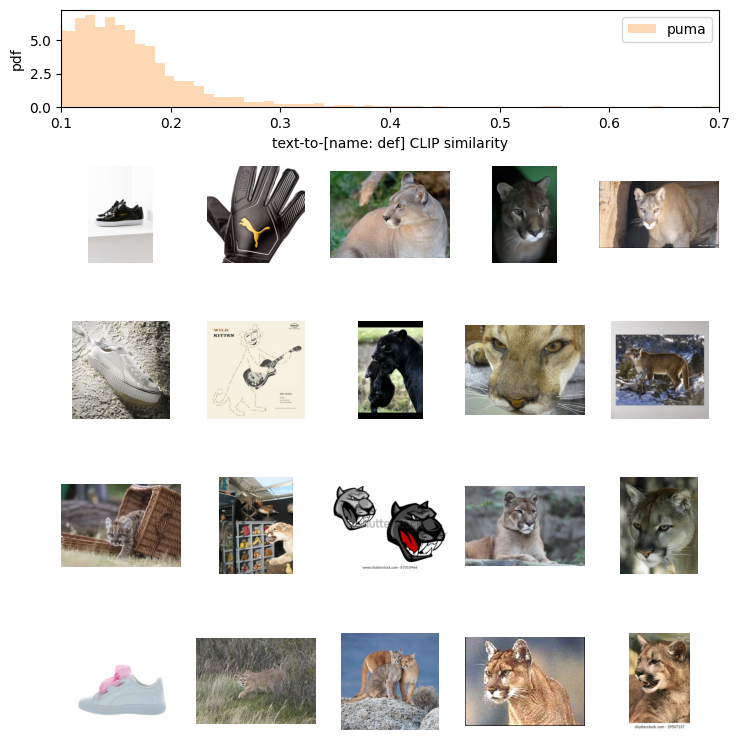

In [61]:
w = 1.5
h = 4
n_bin = len(bin2images)
chosen_sim_th = 0.82

plt.figure(figsize=(n_bin*w, (h + 1)*w))

for b, images in bin2images.items():
    for i_i, image in enumerate(images):
        if i_i >= h:
            continue
            
        plt.subplot(h + 1, n_bin, b + i_i*n_bin + 1 + 1*n_bin)
        
        plt.imshow(image)
        plt.axis('off')
        
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
next(color_cycle)
cl = next(color_cycle)
plt.subplot(h + 1, 1, 1)
plt.hist(sims, bins=min([int(len(sims)/20), 100]), color=cl, alpha=0.3, density=True)  # 500 or 50
plt.legend([lemma])
plt.plot([chosen_sim_th]*2, [0.05, 3], 'k--', alpha=0.5)
plt.xlim((qt_sims[0], qt_sims[n_bin]))
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('pdf')


plt.tight_layout()

plt.savefig(os.path.join('figs', f'demo_text-query-sim-{text_encoder_ver}_bins(lemma_{lemma}).pdf'))

# Sampling

In [62]:
# CLIP
# sim_ths = np.linspace(0.5, 0.9, 20)

# Bert-base
# sim_ths = np.linspace(0.9, 0.99, 20)

# all-mpnet
sim_ths = np.linspace(0.1, 0.7, 20)

n_per_class_th = 1

In [63]:
n_class_per_th = []
n_sample_per_th = []

for sim_th in tqdm(sim_ths):
    n_class = 0
    laionindices_th = set()
    for wnid, laionindices in wnid2laionindices.items():
        sims = np.array(df.loc[laionindices, sim_col].tolist())
        if np.sum(sims > sim_th) >= n_per_class_th:
            n_class += 1
            laionindices_th.update(np.array(laionindices)[sims > sim_th])
                        
    n_class_per_th.append(n_class)
    n_sample_per_th.append(len(laionindices_th))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.72s/it]


In [72]:
# CLIP
# chosen_sim_th = 0.82

# Bert-base
# chosen_sim_th = 0.97

# all-mpnet
chosen_sim_th = 0.55

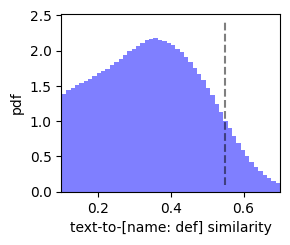

In [73]:
plt.figure(figsize=(3, 2.55))

plt.hist(df[sim_col], bins=100, density=True, color='b', alpha=0.5)  # 100 or 1000

# CLIP
# plt.plot([chosen_sim_th]*2, [0.1, 2.4], 'k--', alpha=0.5)

# Bert-base
# plt.plot([chosen_sim_th]*2, [0.1, 9], 'k--', alpha=0.5)

# all-mpnet
plt.plot([chosen_sim_th]*2, [0.1, 2.4], 'k--', alpha=0.5)

plt.xlim([sim_ths[0], sim_ths[-1]])
plt.xlabel('text-to-[name: def] similarity')
plt.ylabel('pdf')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'text-query-sim-{text_encoder_ver}_sim_distribution_before_filtering.pdf'), bbox_inches='tight')

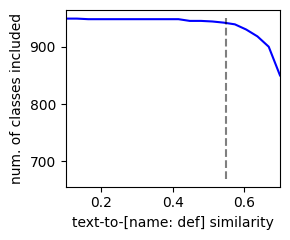

In [74]:
plt.figure(figsize=(3, 2.5))

plt.plot(sim_ths, n_class_per_th, 'b')

# CLIP
# plt.plot([chosen_sim_th]*2, [670, 950], 'k--', alpha=0.5)

# Bert-base
# plt.plot([chosen_sim_th]*2, [170, 950], 'k--', alpha=0.5)

# all-mpnet
plt.plot([chosen_sim_th]*2, [670, 950], 'k--', alpha=0.5)

plt.xlim([sim_ths[0], sim_ths[-1]])
plt.xlabel('text-to-[name: def] similarity')
plt.ylabel('num. of classes included')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'n-class_after_filtering_text-query-sim-{text_encoder_ver}.pdf'), bbox_inches='tight')

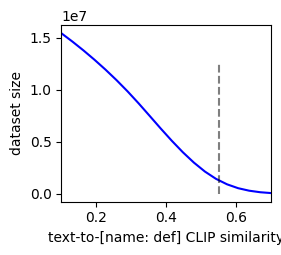

In [75]:
plt.figure(figsize=(3, 2.65))

plt.plot(sim_ths, n_sample_per_th, 'b')
plt.plot([chosen_sim_th]*2, [1.9e4, 1.25e7], 'k--', alpha=0.5)
plt.xlim([sim_ths[0], sim_ths[-1]])
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('dataset size')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'dataset_size_after_filtering_text-query-sim-{text_encoder_ver}.pdf'), bbox_inches='tight')